# Exemple to get started!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm

#For tokenizing sentences
import nltk
nltk.download('punkt')
plt.style.use('seaborn-whitegrid')

# Cte
BASE_PATH = "data/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\pc\AppData\Local\Temp\ipykernel_28492\3519494308.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


### Reading the data

In [14]:
statements_df = pd.read_csv(f"{BASE_PATH}dataset/FOMC/statement.csv")
statements_df

Unnamed: 0        date  \
0             0  1994-02-04   
1             1  1994-03-22   
2             2  1994-04-18   
3             3  1994-05-17   
4             4  1994-08-16   
..          ...         ...   
196         196  2022-05-04   
197         197  2022-06-15   
198         198  2022-07-27   
199         199  2022-09-21   
200         200  2022-11-02   

                                              contents         speaker  \
0    \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
1    \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
2    \n\n[SECTION]\n\nChairman Alan Greenspan annou...  Alan Greenspan   
3    \n\n[SECTION]\n\nThe Federal Reserve today ann...  Alan Greenspan   
4    \n\n[SECTION]\n\nThe Federal Reserve announced...  Alan Greenspan   
..                                                 ...             ...   
196  The Federal Reserve, the central bank of the U...           other   
197  The Federal Reserve, the central bank of the U...           other   
198  The Federal Reserve, the central bank of the U...           other   
199  The Federal Reserve, the central bank of the U...           other   
200  The Federal Reserve, the central bank of the U...           other   

              title  
0    FOMC Statement  
1    FOMC Statement  
2    FOMC Statement  
3    FOMC Statement  
4    FOMC Statement  
..              ...  
196  FOMC Statement  
197  FOMC Statement  
198  FOMC Statement  
199  FOMC Statement  
200  FOMC Statement  

[201 rows x 5 columns]

Preprocess the data ...

In [15]:
# Text clean up
statements_df['text'] = statements_df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
statements_df.drop(columns=['title'], axis=1, inplace=True)

statements_df.size

1005

In [16]:
pos = 95
print('Date: ', datetime.strptime(statements_df.iloc[pos]['date'], '%Y-%m-%d'))
print('Speaker: ', statements_df.iloc[pos]['speaker'])
print('Text: \n\n', statements_df.iloc[pos]['contents'].replace('\n[SECTION]\n', '')[1192:])

Date:  2008-08-05 00:00:00
Speaker:  Ben Bernanke
Text: 

 ysis

Consumer Resources

August 05, 2008

For immediate release                     
                
                

Share

The Federal Open Market Committee decided today to keep its target for the federal funds rate at 2 percent.

Economic activity expanded in the second quarter, partly reflecting growth in consumer spending and exports. However, labor markets have softened further and financial markets remain under considerable stress. Tight credit conditions, the ongoing housing contraction, and elevated energy prices are likely to weigh on economic growth over the next few quarters. Over time, the substantial easing of monetary policy, combined with ongoing measures to foster market liquidity, should help to promote moderate economic growth.

Inflation has been high, spurred by the earlier increases in the prices of energy and some other commodities, and some indicators of inflation expectations have been elevated. The

# Divide the data into a training set and a test set before continuing the analysis.

In [17]:
# from utils.Split import split_and_save

# statements_df, statements_df_test = split_and_save(statements_df, date_split='2022-05-01', filename_prefix='statement', output_path='')

currency = 

# Now let's extract a basic textual analysis of the statements.

### Creating a Financial Dictionary based on Loughran and McDonald

In [18]:
from utils.MasterDictionary import load_masterdictionary

lm_dict_path = (f'{BASE_PATH}dataset/dictionnaries/LoughranMcDonald/Loughran-McDonald_MasterDictionary_1993-2021.csv')
master_dictionaries, md_header, sentiment_categories, sentiment_dictionaries, stopwords, total_documents = \
    load_masterdictionary(lm_dict_path, True, None, True)


 ...Loading Master Dictionary 85,000
Master Dictionary loaded from file:
  data/dataset/dictionnaries/LoughranMcDonald/Loughran-McDonald_MasterDictionary_1993-2021.csv

  master_dictionary has 86,531 words.



In [19]:
import re

lmdict = {'Negative': [word.lower() for word in master_dictionaries.keys() if master_dictionaries[word].negative], 
          'Positive': [word.lower() for word in master_dictionaries.keys() if master_dictionaries[word].positive]}

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

print(f"Number of positive word: {len(lmdict['Positive'])}")
print(f"Number of negative word: {len(lmdict['Negative'])}")

Number of positive word: 354
Number of negative word: 2355


In [20]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [28]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [29]:
Data = statements_df
print(len(Data))
temp = [tone_count_with_negation_check(lmdict,x) for x in Data.text]
temp = pd.DataFrame(temp)

Data['wordcount'] = temp.iloc[:,0].values
Data['NPositiveWords'] = temp.iloc[:,1].values
Data['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
Data['sentiment'] = (Data['NPositiveWords'] - Data['NNegativeWords']) / Data['wordcount'] * 100

Data['Poswords'] = temp.iloc[:,3].values
Data['Negwords'] = temp.iloc[:,4].values


196


In [30]:
temp.tail()

0   1  2                                                  3  \
191  621  18  6  [stable, stability, stability, stability, prog...   
192  727  16  7  [stable, stability, stability, stability, prog...   
193  638  15  7  [stable, stability, stability, stability, prog...   
194  547  12  6  [stable, stability, stability, strengthen, imp...   
195  465  10  6  [stable, stability, stability, strengthen, gai...   

                                                     4  
191  [challenging, adversely, slowed, crisis, persi...  
192  [challenging, adversely, slowed, imbalances, e...  
193  [challenging, adversely, unemployment, decline...  
194  [adversely, unemployment, declined, imbalances...  
195  [unemployment, declined, imbalances, hardship,...

In [31]:
Data.tail()

Unnamed: 0       date                                           contents  \
191         191 2021-09-22  The Federal Reserve, the central bank of the U...   
192         192 2021-11-03  The Federal Reserve, the central bank of the U...   
193         193 2021-12-15  The Federal Reserve, the central bank of the U...   
194         194 2022-01-26  The Federal Reserve, the central bank of the U...   
195         195 2022-03-16  The Federal Reserve, the central bank of the U...   

           speaker                                               text  \
191  Jerome Powell  The Federal Reserve, the central bank of the U...   
192  Jerome Powell  The Federal Reserve, the central bank of the U...   
193  Jerome Powell  The Federal Reserve, the central bank of the U...   
194          other  The Federal Reserve, the central bank of the U...   
195          other  The Federal Reserve, the central bank of the U...   

     wordcount  NPositiveWords  NNegativeWords  sentiment  \
191        621              18               6   1.932367   
192        727              16               7   1.237964   
193        638              15               7   1.253918   
194        547              12               6   1.096892   
195        465              10               6   0.860215   

                                              Poswords  \
191  [stable, stability, stability, stability, prog...   
192  [stable, stability, stability, stability, prog...   
193  [stable, stability, stability, stability, prog...   
194  [stable, stability, stability, strengthen, imp...   
195  [stable, stability, stability, strengthen, gai...   

                                              Negwords  
191  [challenging, adversely, slowed, crisis, persi...  
192  [challenging, adversely, slowed, imbalances, e...  
193  [challenging, adversely, unemployment, decline...  
194  [adversely, unemployment, declined, imbalances...  
195  [unemployment, declined, imbalances, hardship,...

### Plots of the sentiment analysis

Plot positive and negative word counts

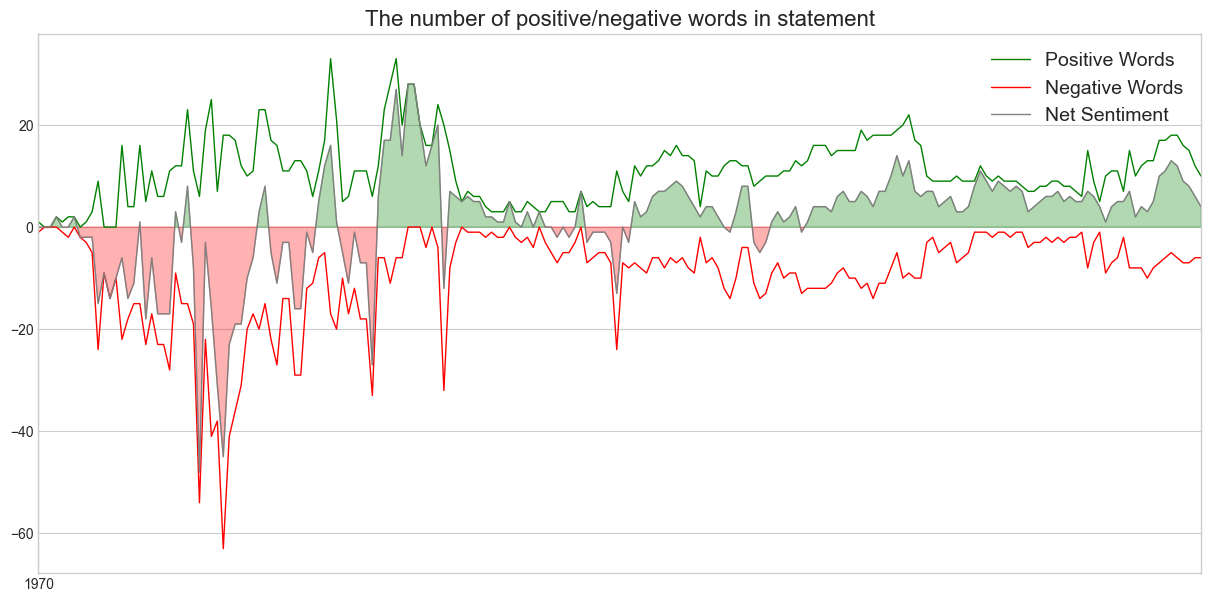

In [34]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(Data.index, Data['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(Data.index, Data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(Data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(Data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(Data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
datemin = Data.index[0]
datemax = Data.index[-1]

ax.set_xlim(datemin, datemax)

ax.grid(True)

plt.show()

In [35]:
# Now it's your turn to continue, you are free to throw away the previous analysis and start on a better basis
...

Now that you know how to start the sentiment analysis process, let's jump ahead a bit and see how to produce an evaluation metric for the part 3

### Example of prediction

Let's forecast the May 2022 using the average of the last three week. 
-> This won't be good, but it's a basic exemple

In [36]:
# Read the data
df = pd.read_csv("data/dataset/FXUSDCAD.csv")

# Split the data
date_split='2022-05-01'
train, test = split_and_save(df, date_split=date_split, filename_prefix="FXUSDCAD")

print(f"First date: {test.iloc[0].date} \n Last date: {test.iloc[-1].date} ")
test.head()

First date: 2022-05-02 00:00:00 
 Last date: 2022-11-03 00:00:00 


date  FXUSDCAD
1331 2022-05-02    1.2895
1332 2022-05-03    1.2847
1333 2022-05-04    1.2810
1334 2022-05-05    1.2822
1335 2022-05-06    1.2882

In [37]:
from datetime import datetime
from datetime import timedelta

# Reset all exchange rate value
pred = test.copy(deep=True)
pred["FXUSDCAD"] = np.nan
pred['date'] = pd.to_datetime(pred['date'], format='%Y-%m-%d')

# Take the mean as a dummy prediction for the exemple
train_mean = train.loc[(df['date'] >= '2022-01-01') & (df['date'] < date_split)].FXUSDCAD.mean()

# Make a dummy prediction for every two week
pred_date = pd.to_datetime(test.iloc[0].date, format='%Y-%m-%d')
while datetime.today() > pred_date:
    pred.loc[pred["date"]==pred_date, "FXUSDCAD"] = train_mean
    pred_date += timedelta(days=14)

# Remove value not predicted
pred.dropna(inplace=True)

Let's evaluate the results

In [38]:
from utils.Evaluate import evaluate

mse = evaluate(pred, "data/test/FXUSDCAD.csv")

 Mean squared error: 0.003172293275522813


Let's export the results

In [24]:
# Export the results as a file
pred.to_csv("data/result/prediction.csv", index=False)

NameError: name 'pred' is not defined

# Now it's your turn! Good luck & Enjoy :)